# Deep Learning Project 2

93.91% 84.450%
noise and eda
synonym replacement, word shuffle, random punctuation

Install and import required libraries

In [ ]:
# !pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=4a1cd8fe9c67cb4d1e950a85976d12f7816b6ec0ea6e8f3cbf10df5da58db203
  Stored in directory: /root/.cache/pip/wheels/47/50/9e/29dc79037d74c3c1bb4a8661fb608e8674b7e4260d6a3f8f51
Successfully built nvidia-ml-py3


In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

2025-04-18 19:21:47.653959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745004107.858126      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745004107.914038      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Tokenizer and Preprocess Data

In [ ]:
import random

# Dirty augmentation utilities
def add_random_punctuation(text, num_punct=3):
    punctuations = list("\™œ#â€“;&")
    words = text.split()
    for _ in range(num_punct):
        insert_idx = random.randint(0, len(words)-1)
        words[insert_idx] += random.choice(punctuations)
    return " ".join(words)

def word_shuffle(text, shuffle_ratio=0.3):
    words = text.split()
    n_shuffle = int(len(words) * shuffle_ratio)
    indices = random.sample(range(len(words)), n_shuffle)
    shuffled = words.copy()
    for i in indices:
        j = random.randint(0, len(words)-1)
        shuffled[i], shuffled[j] = shuffled[j], shuffled[i]
    return " ".join(shuffled)

def dirty_augment(text):
    aug = add_random_punctuation(text)
    aug = word_shuffle(aug)
    return aug


In [ ]:
# Load your clean combined dataset
raw_dataset = load_dataset("ag_news", split="train")
# Get proper label info from original AG News
original_features = load_dataset("ag_news", split="train").features

# Convert to mutable list
data = raw_dataset.to_list()

# Choose ratio to corrupt
dirty_ratio = 0.2
num_dirty = int(dirty_ratio * len(data))

# Shuffle and select
indices = random.sample(range(len(data)), num_dirty)

# Apply dirty augmentation in-place
for idx in indices:
    original_text = data[idx]["text"]
    data[idx]["text"] = dirty_augment(original_text)

# Convert back to Dataset
dirty_injected_dataset = Dataset.from_list(data)


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")
import random

# EDA synonym replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            name = lemma.name().replace("_", " ").lower()
            if name != word:
                synonyms.add(name)
    return list(synonyms)

def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    candidates = [w for w in words if get_synonyms(w)]
    random.shuffle(candidates)

    replaced = 0
    for word in candidates:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            replaced += 1
        if replaced >= n:
            break
    return " ".join(new_words)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
# Convert to list so we can work on it
data = dirty_injected_dataset.to_list()

# Get indices NOT already dirtied (you'll reuse same 20% ratio)
eda_ratio = 0.25
num_eda = int(eda_ratio * len(data))

# Grab samples that were not dirtied (just shuffle and take a new set)
remaining_indices = [i for i in range(len(data))]
eda_indices = random.sample(remaining_indices, num_eda)

for idx in eda_indices:
    text = data[idx]["text"]
    words = text.split()
    n_replace = max(1, int(0.15 * len(words)))  # Replace 15% of words
    data[idx]["text"] = synonym_replacement(text, n_replace)

In [ ]:
from datasets import Dataset

final_augmented_dataset = Dataset.from_list(data)

# Recast label type
original_features = load_dataset("ag_news", split="train").features
final_augmented_dataset = final_augmented_dataset.cast_column("label", original_features["label"])

Casting the dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
base_model = 'roberta-base'

tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = final_augmented_dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = final_augmented_dataset.features['label'].num_classes
class_names = final_augmented_dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
def show_augmented_samples(final_dataset, original_dataset, indices=None, n=5):
    import random
    from termcolor import colored

    if indices is None:
        indices = random.sample(range(len(final_dataset)), n)

    for i in indices:
        original = original_dataset[i]["text"]
        augmented = final_dataset[i]["text"]
        label = final_dataset[i]["label"]

        print(f"\n🔹 Sample {i} — Label: {label}")
        print(colored("Original: ", "cyan"), original)
        print(colored("Augmented:", "green"), augmented)


In [ ]:
show_augmented_samples(final_augmented_dataset, raw_dataset, n=10)


🔹 Sample 54263 — Label: 1
Original:  Footage of Bradley confrontation erased Milton Bradley was back in the Los Angeles Dodgers #39; lineup Thursday, going 2 for 3 with a home run, double and walk in an 8-3 loss to St.
Augmented: Footage of Bradley confrontation erased Milton Bradley was back in the Los Angeles Dodgers #39; lineup Thursday, going 2 for 3 with a home run, double and walk in an 8-3 loss to St.

🔹 Sample 97034 — Label: 0
Original:  Slumping Dollar to Dominate G-20 Meeting (AP) AP - European officials are increasingly alarmed by the U.S. dollar's slump against the euro  #151; but they aren't likely to get help from the United States or Asian countries at the G-20 meeting of industrial and developing countries that opened Saturday.
Augmented: Slumping Dollar to Dominate G-20 Meeting (AP) AP - European officials are increasingly alarmed by the U.S. dollar's slump against the euro  #151; but they aren't likely to get help from the United States or Asian countries at the G-20

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
!pip install peft accelerate transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 484.7 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found 

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# Configure LoRA
lora_config = LoraConfig(
    r=8,  #back to 8
    lora_alpha=8, # back to 8
    target_modules=["query", "value"],
    lora_dropout=0.1, # bumping up dropout
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [ ]:
peft_model = get_peft_model(model, lora_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [ ]:
print("Trainable parameters:")
count = 0
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        count=count+1
        print(name)
print(count)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.sel

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./roberta-lora-agnews-v2",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16, # reducing to 16 to improve generalization
    num_train_epochs=3,
    learning_rate=2e-4, # significant increase, but slightly lower than common lora LR of 2e-2
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    report_to="none"
)

### Start Training

#### Introducing weighted crossentropy loss

Rationale behind adding Weighted Loss Trainer is that we were having uneven performance for different classes (see our metrics per business, science / tech, etc. in plots below)

In [ ]:
import torch
import numpy as np
from collections import Counter

def get_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())

    # Inverse frequency: total / (count * num_classes)
    weights = [total / (counts[i] * num_classes) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [ ]:
from transformers import Trainer

# Adding WeightedLossTrainer after observing uneven performance for different classes
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
train_labels = train_dataset["labels"]
class_weights = get_class_weights(train_labels, num_classes=4)

In [ ]:
trainer = WeightedLossTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

/tmp/ipykernel_31/2440602253.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.202000,0.449617,0.876563,0.878088,0.876825,0.877173
100,0.397500,0.392843,0.876563,0.892682,0.871247,0.877026
150,0.354900,0.340282,0.889062,0.892304,0.889631,0.889132
200,0.291600,0.315821,0.903125,0.906535,0.901593,0.902189
250,0.308700,0.325046,0.909375,0.914273,0.906714,0.908294
300,0.292300,0.310804,0.895312,0.895505,0.897065,0.895000
350,0.315300,0.280527,0.896875,0.897954,0.895439,0.896413
400,0.305500,0.296289,0.904687,0.904570,0.903923,0.903974
450,0.286000,0.290771,0.910937,0.913462,0.908425,0.909588
500,0.274200,0.291662,0.901563,0.904702,0.898027,0.899929


TrainOutput(global_step=11190, training_loss=0.21626653581777783, metrics={'train_runtime': 11239.5285, 'train_samples_per_second': 31.859, 'train_steps_per_second': 0.996, 'total_flos': 6.362076547337779e+16, 'train_loss': 0.21626653581777783, 'epoch': 3.0})

### Training Plots

In [ ]:
logs = trainer.state.log_history

In [ ]:
log_df = pd.DataFrame(logs)
log_df = log_df[log_df["step"].notnull()]  # keep rows that are tied to steps
log_df.reset_index(drop=True, inplace=True)
log_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.2020,1.442902,0.000199,0.013405,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.013405,50,0.449617,0.876563,0.878088,0.876825,0.877173,6.5294,98.018,3.063,NaN,NaN,NaN,NaN,NaN
2,0.3975,2.420634,0.000198,0.026810,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.026810,100,0.392843,0.876563,0.892682,0.871247,0.877026,7.0774,90.429,2.826,NaN,NaN,NaN,NaN,NaN
4,0.3549,1.747264,0.000197,0.040214,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_31/2262595013.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_df["train_loss"] = log_df["loss"].fillna(method="ffill")


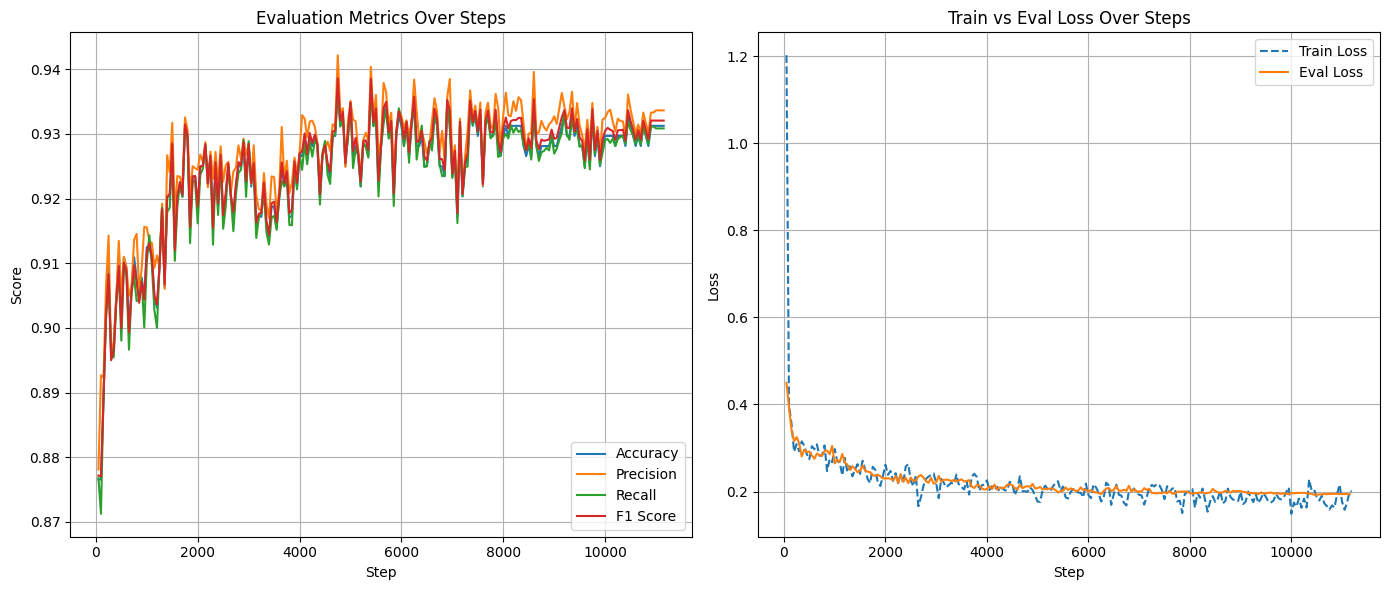

In [ ]:
import matplotlib.pyplot as plt

# Clean the DataFrame: remove rows without step
log_df = log_df[log_df["step"].notnull()]
log_df = log_df.reset_index(drop=True)

# Fill train loss forward (every other row has it missing)
log_df["train_loss"] = log_df["loss"].fillna(method="ffill")

# Filter to rows with evaluation metrics
eval_df = log_df[log_df["eval_accuracy"].notnull()]

# Plotting
def plot_metrics_from_csv(log_df, eval_df):
    plt.figure(figsize=(14, 6))

    # Evaluation Metrics
    plt.subplot(1, 2, 1)
    plt.plot(eval_df["step"], eval_df["eval_accuracy"], label="Accuracy")
    plt.plot(eval_df["step"], eval_df["eval_precision"], label="Precision")
    plt.plot(eval_df["step"], eval_df["eval_recall"], label="Recall")
    plt.plot(eval_df["step"], eval_df["eval_f1"], label="F1 Score")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Over Steps")
    plt.legend()
    plt.grid(True)

    # Training vs Evaluation Loss
    plt.subplot(1, 2, 2)
    plt.plot(log_df["step"], log_df["train_loss"], label="Train Loss", linestyle="--")
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Train vs Eval Loss Over Steps")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(log_df, eval_df)

In [ ]:
# log_df.to_csv("training_metrics V5.1.csv", index=False)
# print("Training metrics saved to training_metrics.csv")

In [ ]:
## Plan to later compare models

# log_df = pd.read_csv("training_metrics V5.1.csv")

## Evaluate Finetuned Model

### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [ ]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import torch

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled is True:
            - metrics (dict)
            - predictions (tensor)
            - true labels (tensor)
        Else:
            - predictions only
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    if labelled:
        accuracy_metric = evaluate.load("accuracy")
        precision_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")
        f1_metric = evaluate.load("f1")

    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(predictions.cpu())

        if labelled:
            labels = batch["labels"].cpu()
            all_labels.append(labels)

            accuracy_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            precision_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            recall_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            f1_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        # Introducing other metrics for better assessment and improvmeent of model
        eval_metric = {
            "accuracy": accuracy_metric.compute(),
            "precision": precision_metric.compute(average="macro"),
            "recall": recall_metric.compute(average="macro"),
            "f1": f1_metric.compute(average="macro"),
        }

        print("Evaluation Metrics:", eval_metric)
        return eval_metric, all_predictions, all_labels
    else:
        return all_predictions

In [ ]:
metrics, predictions, labels = evaluate_model(
    peft_model,
    eval_dataset,
    labelled=True,
    data_collator=data_collator
)

100%|██████████| 80/80 [00:11<00:00,  6.95it/s]

Evaluation Metrics: {'accuracy': {'accuracy': 0.928125}, 'precision': {'precision': 0.931718017156101}, 'recall': {'recall': 0.9265258061897321}, 'f1': {'f1': 0.928521172817542}}


In [ ]:
from sklearn.metrics import classification_report

class_names = final_augmented_dataset.features["label"].names

print("\nPer-Class Metrics:\n")
print(classification_report(labels.numpy(), predictions.numpy(), target_names=class_names))


Per-Class Metrics:

              precision    recall  f1-score   support

       World       0.95      0.89      0.92       145
      Sports       0.97      0.99      0.98       158
    Business       0.93      0.89      0.91       153
    Sci/Tech       0.88      0.94      0.91       184

    accuracy                           0.93       640
   macro avg       0.93      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640



In [ ]:
# import matplotlib.pyplot as plt

# def plot_per_class_f1(preds, labels, class_names):
#     report = classification_report(
#         labels.numpy(),
#         preds.numpy(),
#         target_names=class_names,
#         output_dict=True
#     )
#     f1_scores = {cls: report[cls]["f1-score"] for cls in class_names}

#     plt.figure(figsize=(10, 5))
#     plt.bar(f1_scores.keys(), f1_scores.values())
#     plt.ylim(0, 1)
#     plt.ylabel("F1 Score")
#     plt.title("Per-Class F1 Scores")
#     plt.xticks(rotation=45)
#     plt.grid(axis='y')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# plot_per_class_f1(predictions, labels, class_names)

In [ ]:
!pip install scikit-learn matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, class_names):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)

    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names, rotation=0)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

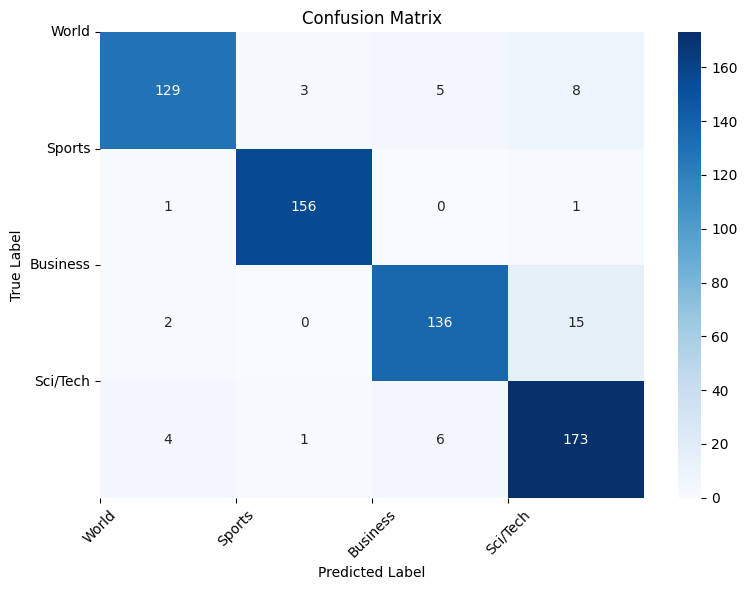

In [ ]:
plot_confusion_matrix(predictions.numpy(), labels.numpy(), class_names)

In [ ]:
# import pandas as pd
# df = pd.DataFrame({"predictions": predictions, "labels": labels})
# df.to_csv("confusion_data.csv", index=False)

### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

df_output.to_csv('/kaggle/working/submission.csv', index=False)
print("Inference complete. Predictions saved to submission.csv")

100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]

Inference complete. Predictions saved to submission.csv
